# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

In [30]:
import pandas as pd
import dalex as dx
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
#https://www.kaggle.com/datasets/vishalmane10/anime-dataset-2022
df = pd.read_csv('Anime.csv')
df.head()

Rank                                               Name  \
0     1  Demon Slayer: Kimetsu no Yaiba - Entertainment...   
1     2                     Fruits Basket the Final Season   
2     3                                    Mo Dao Zu Shi 3   
3     4                   Fullmetal Alchemist: Brotherhood   
4     5                Attack on Titan 3rd Season: Part II   

                                     Japanese_name   Type  Episodes  \
0                    Kimetsu no Yaiba: Yuukaku-hen  TV          NaN   
1                          Fruits Basket the Final  TV         13.0   
2                       The Founder of Diabolism 3  Web        12.0   
3   Hagane no Renkinjutsushi: Full Metal Alchemist  TV         64.0   
4             Shingeki no Kyojin Season 3: Part II  TV         10.0   

              Studio Release_season  \
0           ufotable          Fall    
1  TMS Entertainment         Spring   
2   B.C MAY PICTURES            NaN   
3              Bones         Spring   
4         WIT Studio         Spring   

                                                Tags  Rating  Release_year  \
0  Action, Adventure, Fantasy, Shounen, Demons, H...    4.60        2021.0   
1  Drama, Fantasy, Romance, Shoujo, Animal Transf...    4.60        2021.0   
2  Fantasy, Ancient China, Chinese Animation, Cul...    4.58        2021.0   
3  Action, Adventure, Drama, Fantasy, Mystery, Sh...    4.58        2009.0   
4  Action, Fantasy, Horror, Shounen, Dark Fantasy...    4.57        2019.0   

   End_year                                        Description  \
0       NaN  'Tanjiro and his friends accompany the Hashira...   
1       NaN                  'The final arc of Fruits Basket.'   
2       NaN               'The third season of Mo Dao Zu Shi.'   
3    2010.0  "The foundation of alchemy is based on the law...   
4       NaN  'The battle to retake Wall Maria begins now! W...   

                                     Content_Warning  \
0                                  Explicit Violence   
1  Emotional Abuse,, Mature Themes,, Physical Abu...   
2                                                NaN   
3  Animal Abuse,, Mature Themes,, Violence,, Dome...   
4                    Cannibalism,, Explicit Violence   

                                       Related_Mange  \
0                     Demon Slayer: Kimetsu no Yaiba   
1               Fruits Basket, Fruits Basket Another   
2  Grandmaster of Demonic Cultivation: Mo Dao Zu ...   
3  Fullmetal Alchemist, Fullmetal Alchemist (Ligh...   
4  Attack on Titan, Attack on Titan: End of the W...   

                                       Related_anime  \
0  Demon Slayer: Kimetsu no Yaiba, Demon Slayer: ...   
1  Fruits Basket 1st Season, Fruits Basket 2nd Se...   
2                   Mo Dao Zu Shi 2, Mo Dao Zu Shi Q   
3  Fullmetal Alchemist: Brotherhood Specials, Ful...   
4  Attack on Titan, Attack on Titan 2nd Season, A...   

                                        Voice_actors  \
0  Inosuke Hashibira : Yoshitsugu Matsuoka, Nezuk...   
1  Akito Sohma : Maaya Sakamoto, Kyo Sohma : Yuum...   
2  Lan Wangji, Wei Wuxian, Jiang Cheng, Jin Guang...   
3  Alphonse Elric : Rie Kugimiya, Edward Elric : ...   
4  Armin Arlelt : Marina Inoue, Eren Jaeger : Yuu...   

                                               staff  
0  Koyoharu Gotouge : Original Creator, Haruo Sot...  
1  Natsuki Takaya : Original Creator, Yoshihide I...  
2  Mo Xiang Tong Xiu : Original Creator, Xiong Ke...  
3  Hiromu Arakawa : Original Creator, Yasuhiro Ir...  
4  Hajime Isayama : Original Creator, Tetsurou Ar...

In [32]:
ProfileReport.to_notebook_iframe(ProfileReport(df))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
data = df.copy()
data = data.dropna(subset=['Rating', 'Tags', 'Release_year'])
data.loc[:, 'Episodes'] = data['Episodes'].fillna(1)
data.loc[:, 'Studio'] = data['Studio'].fillna("Unknown")

X = data[['Type', 'Episodes', 'Studio', 'Tags', 'Release_year']]
Y = data['Rating']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


class TagsOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tags_encoded = X['Tags'].str.split(',').str.join('|').str.get_dummies(sep='|')
        return tags_encoded

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, X.columns.difference(['Tags'])),
        ('tags', TagsOneHotEncoder(), ['Tags'])
    ])


X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(X.columns.difference(['Tags']))
tags_feature_names = preprocessor.named_transformers_['tags'].transform(X[['Tags']]).columns
all_feature_names = list(feature_names) + list(tags_feature_names)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

print(X_preprocessed_df.head())


   Episodes_1.0  Episodes_2.0  Episodes_3.0  Episodes_4.0  Episodes_5.0  \
0           1.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   Episodes_6.0  Episodes_7.0  Episodes_8.0  Episodes_9.0  Episodes_10.0  ...  \
0           0.0           0.0           0.0           0.0            0.0  ...   
1           0.0           0.0           0.0           0.0            0.0  ...   
2           0.0           0.0           0.0           0.0            0.0  ...   
3           0.0           0.0           0.0           0.0            0.0  ...   
4           0.0           0.0           0.0           0.0            1.0  ...   

   Supernatural  Time Travel  Trains  Unrequited Love  VTubers

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, Y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.13685086450370715


In [35]:
feature_importances = model.feature_importances_
feature_importance_dict = dict(zip(X_preprocessed_df.columns, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

num_top_features = 50
print(f"Top {num_top_features} Most Important Features:")
for feature_name, importance in sorted_feature_importances[:num_top_features]:
    print(f"{feature_name}: {importance:.4f}")

Top 50 Most Important Features:
Studio_Unknown: 0.0809
 Short Episodes: 0.0385
 Based on a Manga: 0.0297
 Shorts: 0.0288
 Chinese Animation: 0.0188
 Based on a Light Novel: 0.0160
Type_Movie: 0.0145
Type_OVA  : 0.0132
Episodes_1.0: 0.0121
 Drama: 0.0121
 Based on a Web Novel: 0.0119
 Original Work: 0.0102
Episodes_12.0: 0.0099
 Shounen: 0.0088
 Nudity: 0.0085
 Explicit Violence: 0.0083
Release_year_2021.0: 0.0072
 Sci Fi: 0.0062
Type_TV   : 0.0062
Drama: 0.0061
 CG Animation: 0.0061
 Promotional: 0.0060
 Iyashikei: 0.0057
Shorts: 0.0055
 Supernatural: 0.0054
Release_year_2020.0: 0.0053
Release_year_2016.0: 0.0052
Type_Web  : 0.0050
 Explicit Sex: 0.0049
Studio_J.C.Staff: 0.0048
 School Life: 0.0048
 Romance: 0.0047
 Japanese Anime Classic Collection: 0.0047
Studio_Production I.G: 0.0046
Release_year_2014.0: 0.0045
 Slice of Life: 0.0045
Fantasy: 0.0044
 Violence: 0.0044
Action: 0.0044
 Real Robot: 0.0044
Release_year_2019.0: 0.0042
 Fantasy: 0.0040
Studio_Kyoto Animation: 0.0040
Releas

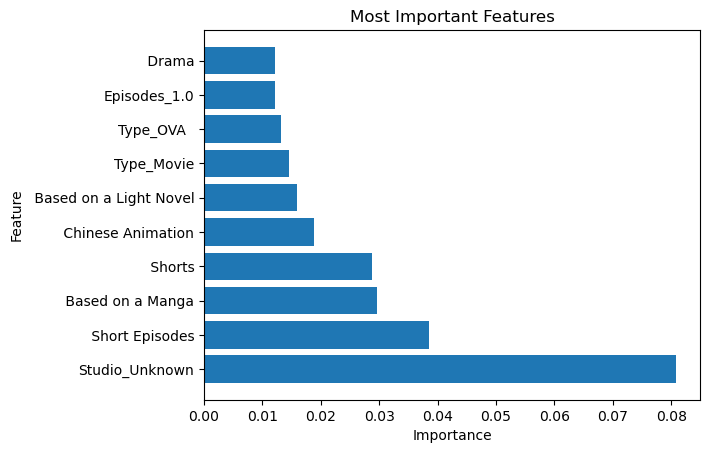

In [36]:
feature_importances = model.feature_importances_
feature_names = all_feature_names
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

plt.barh(list(top_features.keys()), list(top_features.values()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Most Important Features')
plt.show()

In [42]:
feature_importances = model.feature_importances_
feature_importance_dict = dict(zip(X_preprocessed_df.columns, feature_importances))
zero_importance_features = [feature for feature, importance in feature_importance_dict.items() if importance == 0]

print(f"Features with 0 importance: {zero_importance_features}")
print(f"Number of all features: {len(all_feature_names)}")
print(f"Number of features with 0 importance: {len(zero_importance_features)}")

Features with 0 importance:['Episodes_17.0', 'Episodes_29.0', 'Episodes_55.0', 'Episodes_65.0', 'Episodes_66.0', 'Episodes_68.0', 'Episodes_71.0', 'Episodes_80.0', 'Episodes_83.0', 'Episodes_86.0', 'Episodes_87.0', 'Episodes_88.0', 'Episodes_89.0', 'Episodes_91.0', 'Episodes_92.0', 'Episodes_93.0', 'Episodes_94.0', 'Episodes_96.0', 'Episodes_97.0', 'Episodes_99.0', 'Episodes_101.0', 'Episodes_102.0', 'Episodes_107.0', 'Episodes_110.0', 'Episodes_113.0', 'Episodes_114.0', 'Episodes_117.0', 'Episodes_119.0', 'Episodes_127.0', 'Episodes_131.0', 'Episodes_132.0', 'Episodes_135.0', 'Episodes_136.0', 'Episodes_137.0', 'Episodes_145.0', 'Episodes_146.0', 'Episodes_147.0', 'Episodes_150.0', 'Episodes_151.0', 'Episodes_154.0', 'Episodes_155.0', 'Episodes_156.0', 'Episodes_161.0', 'Episodes_162.0', 'Episodes_164.0', 'Episodes_167.0', 'Episodes_170.0', 'Episodes_172.0', 'Episodes_173.0', 'Episodes_175.0', 'Episodes_178.0', 'Episodes_180.0', 'Episodes_181.0', 'Episodes_182.0', 'Episodes_186.0', 'E